In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats
from scipy.stats import norm

import xgboost as xgb
import lightgbm as lgb

import os
os.chdir("/content/drive/MyDrive/Practicum")
#from google.colab import drive
#drive.mount('/content/drive')
import os

from share_funcs import *


import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='Calibri')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [ ]:
# Read data
data = pd.read_csv("/content/drive/MyDrive/Practicum/amercall_pde_100k_final.csv", index_col=0)
data.dropna(axis=0, how='any', inplace=True)
data.head()

,m,T,r,q,v0,theta,kappa,sigma,rho,amercall_pde
0,1.288887,0.527902,0.051012,0.014432,0.024853,1.209090,0.087701,0.205759,-0.667574,0.003338
1,2.846311,1.151904,0.068235,0.024679,0.058919,0.504592,1.840905,0.230414,0.196799,0.022033
2,3.653451,0.444326,0.034813,0.043937,0.424809,1.230969,0.730221,0.897620,0.060239,0.002635
3,2.230911,1.786501,0.053370,0.024511,0.060177,1.927837,0.799849,0.073876,0.084663,0.277423
4,2.508473,1.358587,0.045171,0.034893,0.338931,0.907956,0.986016,0.664361,-0.313718,0.083194


In [ ]:
(data['amercall_pde'] ==0).value_counts()

False    89267
True     10494
Name: amercall_pde, dtype: int64

# American Call Option - RF

In [ ]:
# Data set
rf_data = copy.deepcopy(data)

# Split train/test data set
X_rf = rf_data.drop(['amercall_pde'], axis=1)
y_rf = rf_data['amercall_pde']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=10)

## Model Fit

In [ ]:
# Model fit
%%time
trained_params_rf = {'n_estimators': [50, 100, 200, 400],
                     'max_features': np.arange(1, 9)
                     }
grid_search_rf = trainmodel(RandomForestRegressor, X_train_rf, y_train_rf, trained_params_rf)
rf_cv_results = pd.DataFrame(grid_search_rf.cv_results_)

Best: -0.000035 using {'max_features': 1, 'n_estimators': 400}
CPU times: user 32.8 s, sys: 3.26 s, total: 36 s
Wall time: 1h 27min 52s


In [ ]:
file_path_rf = '/content/drive/MyDrive/Practicum/rf_cv_results_1w.csv'
#rf_cv_results.to_csv(file_path_rf)
rf_cv_results = pd.read_csv(file_path_rf, index_col=0)

In [ ]:
%%time
rfr1 = train_best_reg(RandomForestRegressor, X_train_rf, y_train_rf, X_test_rf, y_test_rf,
                      "RF", max_features=5, n_estimators=400)

Current Best RF Performance:
RandomForestRegressor(max_features=5, n_estimators=400)
Train Set rmse:  0.00467
RF rmse:  0.01238 mae: 0.00792
RF r2:  0.99598
CPU times: user 2min 54s, sys: 1.09 s, total: 2min 55s
Wall time: 2min 56s


In [ ]:
%%time
rfr2 = train_best_reg(RandomForestRegressor, X_train_rf, y_train_rf, X_test_rf, y_test_rf,
                      "RF", max_features=4, n_estimators=400)

Current Best RF Performance:
RandomForestRegressor(max_features=4, n_estimators=400)
Train Set rmse:  0.00478
RF rmse:  0.01296 mae: 0.00831
RF r2:  0.99563
CPU times: user 2min, sys: 1.06 s, total: 2min 1s
Wall time: 2min 2s


## Error Analysis

In [ ]:
# Error
# using model with n estimators = 400
y_test_predict_rf = err_check(rfr1.predict(X_test_rf))
err_rf = y_test_rf - y_test_predict_rf

print('RF Absolute Error (quantile): ')
print(np.around(err_rf.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

RF Absolute Error (quantile): 
0.00    0.000
0.25    0.001
0.50    0.005
0.75    0.011
0.85    0.017
0.90    0.021
0.99    0.042
1.00    0.107
Name: amercall_pde, dtype: float64


In [ ]:
np.corrcoef(y_test_rf,y_test_predict_rf)

array([[1.        , 0.99789665],
       [0.99789665, 1.        ]])

## Feature Importance

In [ ]:
# Model Feature Importance
rf_feature_importance = pd.Series(rfr1.feature_importances_ / rfr1.feature_importances_.sum(),
                                  index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(rf_feature_importance.index, rf_feature_importance)
plt.title("Random Forest: Feature Importance\n$m \in [0.2, 5,0]$");

# American Call Option - XGBoost

In [ ]:
xgb_data = copy.deepcopy(data)

# train/test data set for XGB
X_xgb = xgb_data.drop(['amercall_pde'], axis=1)
y_xgb = xgb_data['amercall_pde']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=10)

## Model Fit

In [ ]:
param_xgb = {'n_estimators': [200, 400, 800],
             'subsample': [0.6, 0.8],
             'colsample_bytree': [0.8, 1],
             'lambda_l2': [0, 1],
             'min_child_weight': [1, 5, 10],
             'max_depth': [4, 5, 6]
             }
grid_xgb = trainmodel(xgb.XGBRegressor, X_train_xgb, y_train_xgb, param_xgb)
xgb_cv_results = pd.DataFrame(grid_xgb.cv_results_)

In [ ]:
file_path_xgb = '/content/drive/MyDrive/Practicum/xgb_cv_results_1w.csv'
#xgb_cv_results.to_csv(file_path_xgb)
xgb_cv_results = pd.read_csv(file_path_xgb, index_col=0)

In [ ]:
xgb1 = train_best_reg(xgb.XGBRegressor, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb,
                      'XGB', **{'colsample_bytree': 0.9, 'lambda_l1': 0,'lambda_l2': 0, 'max_depth': 6,'eta':0.05, 'min_child_weight': 2, 'n_estimators': 3000, 'subsample': 0.8,'gamma':0})

[00:11:59] WARNING: ../src/learner.cc:767: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

Current Best XGB Performance:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda_l1=0,
             lambda_l2=0, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, ...)
Train Set rmse:  0.00268
XGB rmse:  0.00523 mae: 0.0038
XGB r2:  0.99928


In [ ]:
cv_params = {'eta': [0.05,0.06,0.07]}
other_params = {'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 6, 'min_child_weight': 2, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train_xgb, y_train_xgb)

print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
参数的最佳取值：{'eta': 0.05}
最佳模型得分:-4.553224439847784e-05


## Error Analysis

In [ ]:
# Error
y_test_predict_xgb = err_check(xgb1.predict(X_test_xgb))
err_xgb = y_test_xgb - y_test_predict_xgb

print('XGM Absolute Error (quantile): ')
print(np.around(err_xgb.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

XGM Absolute Error (quantile): 
0.00    0.000
0.25    0.001
0.50    0.002
0.75    0.005
0.85    0.007
0.90    0.008
0.99    0.016
1.00    0.039
Name: amercall_pde, dtype: float64


## Feature Importance

In [ ]:
# Model Feature Importance
xgb_feature_importance = pd.Series(xgb1.feature_importances_ / xgb1.feature_importances_.sum(),
                                   index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(xgb_feature_importance.index, xgb_feature_importance)
plt.title("XGB: Feature Importance\n$m \in [0.2, 5.0]$");

# American Call Option - LightGBM

## Model Fit

In [ ]:
lgb_data = copy.deepcopy(data)

# train/test data set for LGBM
X_lgb = lgb_data.drop(['amercall_pde'], axis=1)
y_lgb = lgb_data['amercall_pde']
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb, y_lgb, test_size=0.3, random_state=10)

In [ ]:
param_lgb = {'num_leaves': [40,50,60],
             'min_data_in_leaf': [16,18,20,22,24,26],
             'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
             'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
             'max_depth': [3,4,5],
             'n_estimators': [400,600,800,1000],
             'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
             'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
             }
grid_lgb = trainmodel(lgb.LGBMRegressor, X_train_lgb, y_train_lgb, param_lgb)
lgb_cv_results = pd.DataFrame(grid_lgb.cv_results_)

In [ ]:
file_path_lgb = '/content/drive/MyDrive/Practicum/lgb_cv_results_1w.csv'
#lgb_cv_results.to_csv(file_path_lgb)
lgb_cv_results = pd.read_csv(file_path_lgb, index_col=0)

In [ ]:
lgb2 = train_best_reg(lgb.LGBMRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb,
                      'LGB', **{'reg_alpha': 0.08, 'reg_lambda':0.5,'max_depth':8,'n_estimators':6000,
                                'num_leaves': 30, 'min_child_samples': 20,'min_child_weight':0.001,
                                'colsample_bytree':0.8,'subsample':0.6,
                                'learning_rate':0.05})

Current Best LGB Performance:
LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=8,
              n_estimators=6000, num_leaves=30, reg_alpha=0.08, reg_lambda=0.5,
              subsample=0.6)
Train Set rmse:  0.00269
LGB rmse:  0.00446 mae: 0.00328
LGB r2:  0.99948


In [ ]:
from sklearn.model_selection import GridSearchCV
model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=0.1, n_estimators=1000, num_leaves=40,max_depth=8, min_child_samples=20,min_child_weight=0.001,
                              metric='rmse', bagging_fraction = 0.6,feature_fraction = 0.8)


params_test1={
'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(X_train_lgb, y_train_lgb)

gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


({'reg_alpha': 0.08, 'reg_lambda': 0.5}, -4.27760020799271e-05)

In [ ]:
params = {
'reg_alpha': 0.08, 'reg_lambda':0.5,'max_depth':8,
                                'num_leaves': 30, 'min_child_samples': 20,'min_child_weight':0.001,
                                'colsample_bytree':0.8,'subsample':0.6,
                                'learning_rate':0.05
    }

data_train = lgb.Dataset(X_train_lgb, y_train_lgb, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

## Error Analysis

In [ ]:
# Error
y_test_predict_lgb = err_check(lgb2.predict(X_test_lgb))
err_lgb = y_test_lgb - y_test_predict_lgb

print('LGB Absolute Error (quantile): ')
print(np.around(err_lgb.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

LGB Absolute Error (quantile): 
0.00    0.000
0.25    0.001
0.50    0.002
0.75    0.004
0.85    0.006
0.90    0.007
0.99    0.013
1.00    0.035
Name: amercall_pde, dtype: float64


In [ ]:
np.corrcoef(y_test_predict_lgb,y_test_lgb)

array([[1.        , 0.99964753],
       [0.99964753, 1.        ]])

## Feature Importance

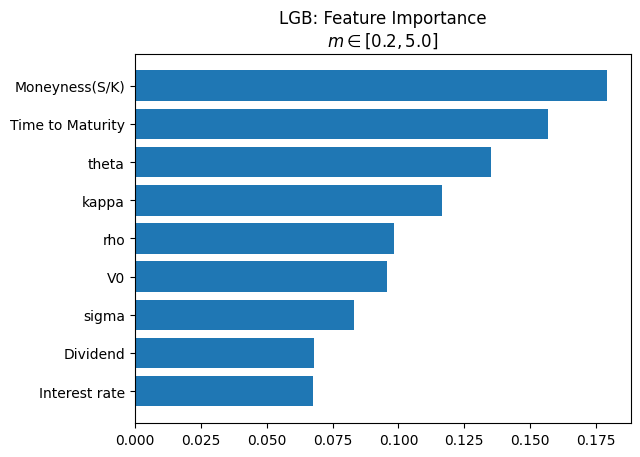

In [ ]:
# Model Feature Importance
lgb_feature_importance = pd.Series(lgb2.feature_importances_ / lgb2.feature_importances_.sum(),
                                   index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(lgb_feature_importance.index, lgb_feature_importance)
plt.title("LGB: Feature Importance\n$m \in [0.2, 5.0]$");

# American Call Option - ANN

In [ ]:
X_ann = data.drop(columns=['eurocall_fourier'], axis=1)
#X_ann = X_ann.drop(columns=['g_eurocall'], axis=1)
y_ann = data['eurocall_fourier']

#X_ann['T_sigma'] = X_ann.g_T * X_ann.g_sigma
X_ann['T_q'] = X_ann.g_T * X_ann.g_q
X_ann['T_r'] = X_ann.g_T * X_ann.g_r

X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann, y_ann, test_size=0.3, random_state=10)
#train_size = int(0.8 * len(X_train_ann))
#X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(X_train_ann, y_train_ann, test_size=0.3, random_state=10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-8c98b4abf13b>", line 6, in <module>
    X_ann['T_q'] = X_ann.g_T * X_ann.g_q
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py", line 5487, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'g_T'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultra

AttributeError: ignored

## Model Fit

In [ ]:
class PricingNetwork2(nn.Module):
  def __init__(self, mean=X_train_ann.mean(axis=0).values.astype(np.float32), std=X_train_ann.std(axis=0).values.astype(np.float32), neurons=64, x_features=X_train_ann.shape[1]):
  #def __init__(self, neurons=64, x_features=5):
    super(PricingNetwork2,self).__init__()
    self.mean = mean
    self.std = std
    self.bottleneck = nn.Sequential(nn.Linear(x_features, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     #nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU())
    #self.bottleneck = nn.ModuleList([nn.Linear(x_features, neurons), nn.LeakyReLU()] + [nn.Linear(neurons, neurons), nn.LeakyReLU()] * 4)
    self.final_layer = nn.Linear(neurons, 1)

  def forward(self, X, **kwargs):
    #X = (X - np.array([2.59564865,1.00528802,0.03986204,0.02523768,1.06051767], dtype=np.float32)) / np.array([1.38237971, 0.57541136, 0.02325452, 0.01445998, 0.55268058],dtype=np.float32)
    #(X - X.mean(axis=0))/X.std(axis=0)
    X = (X - self.mean) / self.std
    X = self.bottleneck(X)
    X  = self.final_layer(X)
    return X

## Error Analysis

In [ ]:
ann_model = torch.load('/content/drive/MyDrive/practicum_data-American_Option/with_eurocall.pt')

print('ANN Absolute Error (quantile): ')
with torch.no_grad():
  err_ann = np.around((y_test_ann - pd.Series(ann_model(torch.tensor(X_test_ann.values.astype(np.float32))).flatten(), index=X_test_ann.index)), decimals=3)
print((err_ann.abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.99,1])))

ANN Absolute Error (quantile): 
0.00    0.000
0.25    0.000
0.50    0.000
0.75    0.001
0.85    0.002
0.90    0.002
0.99    0.005
1.00    0.026
dtype: float64


# Summary

In [ ]:
import pandas as pd
err_table = pd.concat([X_test_rf, err_rf.abs(), err_xgb.abs(), err_lgb.abs()], axis=1)
err_table.columns = ['m', 'T', 'r', 'q', 'v0','theta','kappa','sigma','rho',  'abs_err_rf', 'abs_err_xgb', 'abs_err_lgb']
err_table.head()

,m,T,r,q,v0,theta,kappa,sigma,rho,abs_err_rf,abs_err_xgb,abs_err_lgb
89258,1.019669,0.371678,0.076140,0.007162,0.098172,1.620106,1.400043,0.826998,0.459106,0.016841,0.004615,0.001509
52619,2.153159,0.102476,0.027645,0.016401,0.162017,0.208677,0.899514,0.050055,0.661722,0.000192,0.000000,0.001763
309,0.526073,0.103201,0.078652,0.012127,0.496933,1.385173,0.459829,0.707939,0.851734,0.004969,0.003931,0.005641
90521,0.239742,1.429044,0.006554,0.001690,0.243443,0.549296,1.706782,0.409496,-0.894303,0.000747,0.003573,0.002027
5606,1.740781,0.561917,0.023623,0.018533,0.125326,0.858069,1.609494,0.941547,0.876019,0.015458,0.003282,0.003073


## Moneyness

In [ ]:
print('#OTM = ', err_table[err_table['m'] > 1].shape[0], '; %OTM = ', err_table[err_table['m'] > 1].shape[0]/err_table.shape[0])
print('#ATM = ', err_table[err_table['m'] == 1].shape[0], '; %ATM = ', err_table[err_table['m'] == 1].shape[0]/err_table.shape[0])
print('#ITM = ', err_table[err_table['m'] < 1].shape[0], '; %ITM = ', err_table[err_table['m'] < 1].shape[0]/err_table.shape[0])

#OTM =  24981 ; %OTM =  0.8369685395517137
#ATM =  0 ; %ATM =  0.0
#ITM =  4866 ; %ITM =  0.16303146044828626


In [ ]:
# OTM
np.around(err_table[err_table['m'] > 1].quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]), decimals=3)

,m,T,r,q,v0,theta,kappa,sigma,rho,abs_err_rf,abs_err_xgb,abs_err_lgb
0.00,1.005,0.005,0.000,0.000,0.010,0.014,0.012,0.012,-0.899,0.000,0.000,0.000
0.25,2.052,0.537,0.021,0.012,0.123,0.638,0.640,0.229,-0.445,0.001,0.001,0.001
0.50,2.998,1.037,0.042,0.026,0.246,1.148,1.141,0.453,-0.015,0.004,0.002,0.002
0.75,3.894,1.511,0.060,0.038,0.371,1.601,1.590,0.693,0.453,0.011,0.005,0.004
0.85,4.340,1.703,0.068,0.043,0.412,1.729,1.764,0.811,0.646,0.016,0.006,0.006
0.90,4.549,1.802,0.072,0.045,0.439,1.824,1.845,0.866,0.723,0.021,0.008,0.007
0.95,4.793,1.896,0.076,0.048,0.469,1.915,1.922,0.921,0.813,0.028,0.010,0.009
0.99,4.968,1.982,0.079,0.049,0.495,1.979,1.982,0.979,0.886,0.045,0.016,0.013
1.00,4.993,1.997,0.080,0.050,0.500,1.999,1.994,0.999,0.899,0.376,0.391,0.374


In [ ]:
# ITM
np.around(err_table[err_table['m'] < 1].quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]), decimals=3)

,m,T,r,q,v0,theta,kappa,sigma,rho,abs_err_rf,abs_err_xgb,abs_err_lgb
0.00,0.204,0.005,0.000,0.000,0.010,0.012,0.021,0.012,-0.899,0.000,0.000,0.000
0.25,0.381,0.549,0.021,0.012,0.126,0.662,0.644,0.224,-0.419,0.003,0.002,0.002
0.50,0.579,1.057,0.043,0.026,0.246,1.140,1.141,0.460,0.000,0.006,0.004,0.005
0.75,0.837,1.535,0.060,0.038,0.364,1.607,1.578,0.701,0.464,0.013,0.007,0.008
0.85,0.896,1.707,0.068,0.043,0.406,1.734,1.746,0.811,0.647,0.018,0.008,0.010
0.90,0.918,1.802,0.072,0.045,0.434,1.828,1.838,0.868,0.732,0.021,0.010,0.011
0.95,0.944,1.894,0.077,0.048,0.469,1.916,1.919,0.917,0.813,0.027,0.012,0.014
0.99,0.973,1.981,0.079,0.049,0.493,1.979,1.978,0.986,0.891,0.042,0.018,0.021
1.00,0.997,1.997,0.080,0.050,0.500,1.999,1.994,0.999,0.899,0.074,0.035,0.036
